### 1. Import

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from agent import Agent, img_stack
import time
from collections import deque
import matplotlib
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

seed = 0 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

action_repeat = 10
env = gym.make('CarRacing-v0', verbose=0)
state = env.reset()
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold', reward_threshold)



agent = Agent(device)

device:  cuda


/home/dan/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


env.action_space.shape:  (3,)
reward_threshold 900


### 2. Image Preprocessing

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


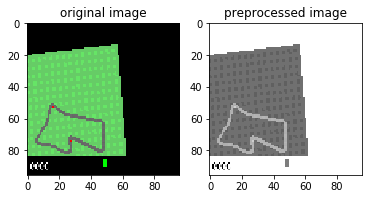

In [2]:
# show what a preprocessed image looks like
frame, _, _, _ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

### 2. Class  Wrapper

In [3]:
class Wrapper():
    """
    Environment wrapper for CarRacing 
    """

    def __init__(self, env):
        self.env = env  

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, die, _ = env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die


    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [4]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '%s/%s_%s.pth' % (directory, filename, suffix))    

In [5]:
def load(agent, directory, filename, suffix):
    agent.net.load_state_dict(torch.load('%s/%s_%s.pth' % (directory, filename, suffix)))
load(agent, 'dir_chk', 'model_weights','final')

In [6]:
import os
def load2(agent, directory, filename):
    agent.net.load_state_dict(torch.load(os.path.join(directory,filename)))

In [7]:
import json
with open("metadata_0003L2.json","r") as file:
    obj = json.load(file)
    scores = obj["scores_array"]
    avg_scores = obj["avg_scores_array"]

1617


### 2. Train Agent


In [9]:

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf           


def ppo_train(n_episodes=5000, save_every=500,convergence_check_it = 0):
    load2(agent, 'dir_chk', 'model_weights_final.pth')
    scores_deque = deque(maxlen=100)
#     scores_array = []
#     avg_scores_array = []
    scores_array = scores
    avg_scores_array = avg_scores

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    since_improve = 0
    max_avg = -100000
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if avg_score > max_avg:
            max_avg = avg_score
            since_improve = 0
        else:
            since_improve += 1
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights%d'%i_episode, suf)
            
        if np.mean(scores_deque) > reward_threshold:
            if convergence_check_it == 0:
                print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                      .format(running_score, avg_score))
                break
            else:
                if since_improve > convergence_check_it:
                        print("reached convergence")
                        break
                
            
    return scores_array, avg_scores_array    
            
# scores, avg_scores  = ppo_train()    
scores2, avg_scores2 = ppo_train(convergence_check_it=20)

Ep. 0, Ep.Timesteps 100, Score: 859.53, Avg.Score: 859.53, Run.Score 8.60, Time: 00:00:09 
Ep. 1, Ep.Timesteps 100, Score: 926.17, Avg.Score: 892.85, Run.Score 17.77, Time: 00:00:17 
Ep. 2, Ep.Timesteps 99, Score: 1001.90, Avg.Score: 929.20, Run.Score 27.61, Time: 00:00:25 
Ep. 3, Ep.Timesteps 100, Score: 896.02, Avg.Score: 920.91, Run.Score 36.30, Time: 00:00:33 
Ep. 4, Ep.Timesteps 100, Score: 934.78, Avg.Score: 923.68, Run.Score 45.28, Time: 00:00:41 
Ep. 5, Ep.Timesteps 100, Score: 936.45, Avg.Score: 925.81, Run.Score 54.19, Time: 00:00:50 
Ep. 6, Ep.Timesteps 100, Score: 863.33, Avg.Score: 916.89, Run.Score 62.28, Time: 00:00:58 
Ep. 7, Ep.Timesteps 100, Score: 921.77, Avg.Score: 917.50, Run.Score 70.88, Time: 00:01:06 
Ep. 8, Ep.Timesteps 100, Score: 862.54, Avg.Score: 911.39, Run.Score 78.80, Time: 00:01:14 
Ep. 9, Ep.Timesteps 100, Score: 793.55, Avg.Score: 899.61, Run.Score 85.94, Time: 00:01:22 
Ep. 10, Ep.Timesteps 100, Score: 955.02, Avg.Score: 904.64, Run.Score 94.63, Time

In [37]:
# agent = Agent(device)

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf           


def ppo_train(n_episodes=5000, save_every=100):
    
    scores_deque = deque(maxlen=100)
    scores_array = scores
    avg_scores_array = avg_scores    

    timestep_after_last_save = 0
    
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()
    
    i_lim = 0
    
    for i_episode in range(n_episodes):
        
        timestep = 0
        total_reward = 0
        
        ## score = 0
        state = env_wrap.reset()

        while True:    
            
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step( 
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            
            timestep += 1  
            timestep_after_last_save += 1
            
            if done or die:
                break
                
        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        s = (int)(time.time() - time_start)        
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  
       
        
        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights%d'%i_episode, suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break
            
    return scores_array, avg_scores_array    
            
scores, avg_scores  = ppo_train()            

Ep. 0, Ep.Timesteps 14, Score: -3.97, Avg.Score: -3.97, Run.Score -0.04, Time: 00:00:01 
Ep. 1, Ep.Timesteps 15, Score: -3.47, Avg.Score: -3.72, Run.Score -0.07, Time: 00:00:02 
Ep. 2, Ep.Timesteps 15, Score: -2.47, Avg.Score: -3.30, Run.Score -0.10, Time: 00:00:03 
Ep. 3, Ep.Timesteps 14, Score: -1.03, Avg.Score: -2.73, Run.Score -0.11, Time: 00:00:04 
Ep. 4, Ep.Timesteps 12, Score: -2.04, Avg.Score: -2.60, Run.Score -0.13, Time: 00:00:05 
Ep. 5, Ep.Timesteps 13, Score: -2.72, Avg.Score: -2.62, Run.Score -0.15, Time: 00:00:07 
Ep. 6, Ep.Timesteps 13, Score: -0.18, Avg.Score: -2.27, Run.Score -0.15, Time: 00:00:08 
Ep. 7, Ep.Timesteps 16, Score: -2.60, Avg.Score: -2.31, Run.Score -0.18, Time: 00:00:09 
Ep. 8, Ep.Timesteps 13, Score: -4.78, Avg.Score: -2.58, Run.Score -0.22, Time: 00:00:10 
Ep. 9, Ep.Timesteps 13, Score: 2.16, Avg.Score: -2.11, Run.Score -0.20, Time: 00:00:11 
Ep. 10, Ep.Timesteps 13, Score: -3.01, Avg.Score: -2.19, Run.Score -0.23, Time: 00:00:12 
Ep. 11, Ep.Timesteps 

KeyboardInterrupt: 

In [11]:
save(agent, 'dir_chk', 'model_weights', 'final2')

In [7]:
import json
metadata = {"scores_array": scores, "avg_scores_array": avg_scores}
with open("metadata_0003L2.json","w") as file:
    json.dump(metadata,file)

length of scores:  1676 , len of avg_scores:  1676


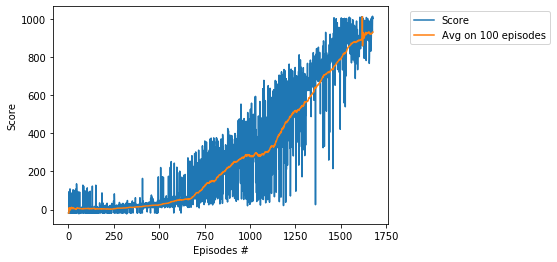

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()


length of scores:  2760 , len of avg_scores:  2760


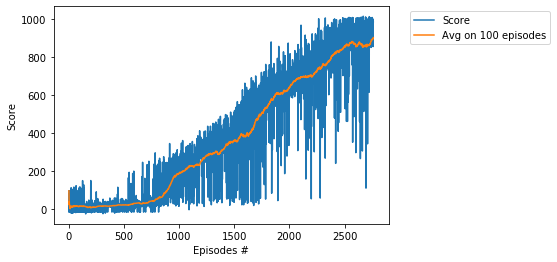

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
env.close()